# Import the scVI model

In [1]:
%matplotlib inline

from scvi import scVI

import tensorflow as tf
import numpy as np
import time
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from benchmarking import *

plt.style.use('ggplot')

# Loading and filtering data

In [2]:
X = pd.read_csv("expression.bin", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
_, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression_data = np.array(X, dtype=np.int)[1:]

# keep the most variable genes according to the Biscuit ICML paper
selected = np.std(expression_data, axis=0).argsort()[-558:][::-1]
expression_data = expression_data[:, selected]
gene_names = gene_names[selected].astype(str)

#train test split for log-likelihood scores
expression_train, expression_test, c_train, c_test = train_test_split(expression_data, labels)

In [3]:
expression_train.shape

(2253, 558)

# Getting prior for scaling parameters
Get the log library size and its mean and variance

In [4]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# Loading scVI on memory

In [5]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=10)

# Tensorflow session

In [6]:
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training

In [7]:
batch_size = 100

In [8]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index].astype(np.float32)

In [9]:
def train_model(num_epochs, expression_train, expression_test):
    train_loss = []
    valid_loss = []
    
    iterep = int(expression_train.shape[0] / float(batch_size)) - 1  
    
    for t in range(iterep * num_epochs):
        # arrange data in batches
        x_train = next_batch(expression_train, batch_size)
        x_test = next_batch(expression_test, batch_size)

        #prepare data dictionaries
        dic_train = {x: x_train}
        dic_test = {x: expression_test} 
        
        # run an optimization set
        _, l_tr = sess.run([model.train_step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:          
            print(epoch)
            l_t = sess.run((model.loss), feed_dict=dic_test)
            
            print('Train / Validation performance:', l_tr, l_t)
            
            if np.isnan(l_tr):
                break
        
            train_loss.append(l_tr)
            valid_loss.append(l_t)
            
    return train_loss, valid_loss

In [10]:
train_loss, valid_loss = train_model(100, expression_train, expression_test)

0.0
Train / Validation performance: 40988.805 37729.188
1.0
Train / Validation performance: 39879.64 37282.117
2.0
Train / Validation performance: 34545.695 35706.84
3.0
Train / Validation performance: 35256.297 34468.945
4.0
Train / Validation performance: 32873.234 33970.613
5.0
Train / Validation performance: 35067.484 33748.945
6.0
Train / Validation performance: 32207.24 33698.188
7.0
Train / Validation performance: 33435.88 33453.562
8.0
Train / Validation performance: 36013.242 33310.586
9.0
Train / Validation performance: 29140.678 33190.086
10.0
Train / Validation performance: 28408.363 32972.914
11.0
Train / Validation performance: 34293.65 32863.37
12.0
Train / Validation performance: 33161.066 32622.914
13.0
Train / Validation performance: 31167.848 32539.955
14.0
Train / Validation performance: 33246.457 32336.432
15.0
Train / Validation performance: 31571.42 32307.756
16.0
Train / Validation performance: 29082.47 32251.936
17.0
Train / Validation performance: 27112.555 31

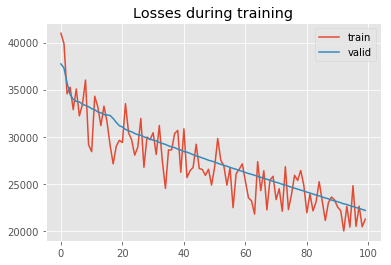

In [11]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('Losses during training')
plt.show()

# Clustering

We can here sample fron the latent space, you can verify that the clustering metrics are robust with respect to different samples from the variational posterior

In [12]:
# Encode the data
latent = sess.run(model.z, feed_dict={x: expression_train})

In [13]:
# Evaluate clusters in latent space: the higher the distance metrics, the 
# better the classes are separated
print(distances_metrics(latent, c_train))

{'nne': 0.6116289391921882, 'silhouette': 0.015303601}


# Visualization

Our latent space is low-dimensional and therefore tSNE friendly !

In [14]:
def show_latent(latent, labels):
    plt.figure(figsize=(10, 10))

    if latent.shape[1] > 2:
        latent = TSNE().fit_transform(latent)
        plt.axis("off")
        
    plt.scatter(latent[:, 0], latent[:, 1], c=labels,
                    cmap=plt.get_cmap("tab10", 7), edgecolors='none', s=30, alpha=0.7)
    plt.title("Latent space for scVI")

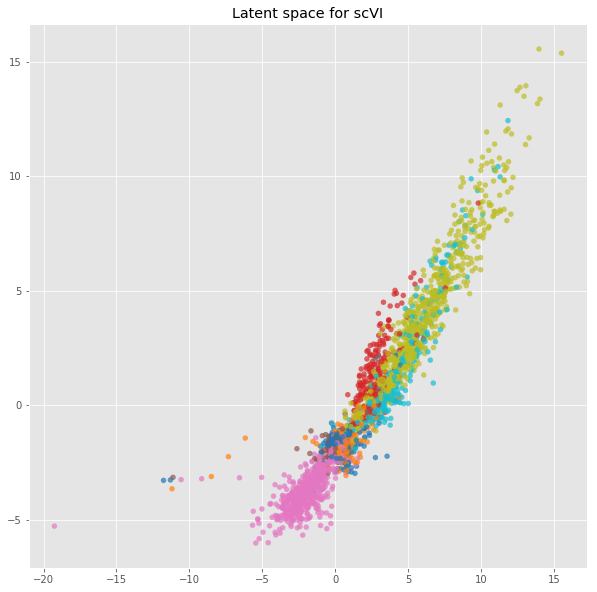

In [15]:
show_latent(latent, c_train)

# Imputation

We now turn to the imputation result. For that, we need to recomplete scVI's inference on corrupted data. That means clearing the computation graph of TensorFlow and starting with a new one. We corrupt the data by uniform sampling over the non-zero entries (10%)

In [16]:
# Corrupt the data with zeros at known positions
X_zero, i, j, ix = dropout(expression_train, decay=0.)

In [17]:
print('Zero proportion in original data set:')
print(1 - np.count_nonzero(expression_train) / expression_train.size)

Zero proportion in original data set:
0.28997338475024137


In [18]:
print('Zero proportion in corrupted data set:')
print(1 - np.count_nonzero(X_zero) / X_zero.size)

Zero proportion in corrupted data set:
0.28997338475024137


In [19]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')

model = scVI(x, n_hidden=15)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
train_loss, valid_loss = train_model(100, X_zero, expression_test)

0.0
Train / Validation performance: 43065.363 38324.402
1.0
Train / Validation performance: 35184.547 37787.777
2.0
Train / Validation performance: 35995.96 35892.77
3.0
Train / Validation performance: 34325.34 34827.75
4.0
Train / Validation performance: 36971.363 34497.477
5.0
Train / Validation performance: 29690.168 34172.387
6.0
Train / Validation performance: 34290.344 34111.15
7.0
Train / Validation performance: 32782.242 33930.164
8.0
Train / Validation performance: 31590.71 33746.004
9.0
Train / Validation performance: 31740.28 33583.574
10.0
Train / Validation performance: 35174.44 33372.04
11.0
Train / Validation performance: 31610.682 33278.688
12.0
Train / Validation performance: 28648.422 33168.98
13.0
Train / Validation performance: 30790.107 32944.496
14.0
Train / Validation performance: 30459.045 32854.797
15.0
Train / Validation performance: 33668.855 32942.53
16.0
Train / Validation performance: 29985.842 32788.324
17.0
Train / Validation performance: 34326.26 32499.

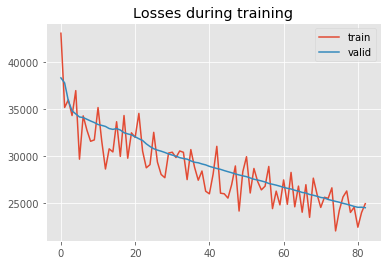

In [21]:
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.title('Losses during training')
plt.show()

In [22]:
# Get Poisson means for zeroed out points
rate_ = sess.run(model.px_rate, {x: X_zero} )

# Compute the imputation error at zeroed out points
imputation_error(rate_, expression_train, X_zero, i, j, ix)

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan